<a href="https://colab.research.google.com/github/matthew-e-thomas/Plant_Image_Project/blob/main/model_experiments_Plant_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries, get paths ready, and clone PlantDoc Repo

In [1]:
import numpy as np
import tensorflow as tf
import IPython.display as display
print(tf.__version__)

2.3.0


In [ ]:
!python --version

Python 3.6.9


In [2]:
!git clone https://github.com/matthew-e-thomas/PlantDoc-Dataset.git

Cloning into 'PlantDoc-Dataset'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 2661 (delta 18), reused 3 (delta 1), pack-reused 2628
Receiving objects: 100% (2661/2661), 932.25 MiB | 23.05 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Checking out files: 100% (2578/2578), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#run this if cloning plantdoc github
from pathlib import Path
data_dir = Path.cwd() / 'PlantDoc-Dataset'

In [4]:
train_dir = data_dir.joinpath('train')
test_dir = data_dir.joinpath('test')

In [ ]:
#CLASS_NAMES_TRAIN = [item.name for item in train_dir.glob('*')]

In [ ]:
#run this if using improved plantdoc dataset from your google drive
# import os
# os.chdir('/content/drive/My Drive')

The next few cells are for reading in the dataset as a tfrecords, if desired

In [ ]:
#!unzip PlantDoc.v1-resize-416x416.tfrecord.zip

Archive:  PlantDoc.v1-resize-416x416.tfrecord.zip
 extracting: train/leaves.tfrecord   
 extracting: train/leaves_label_map.pbtxt  
 extracting: test/leaves.tfrecord    
 extracting: test/leaves_label_map.pbtxt  
 extracting: README.roboflow.txt     
 extracting: README.dataset.txt      


In [ ]:
# filepaths = ["train/leaves.tfrecord"]
# dataset = tf.data.TFRecordDataset(filepaths)
# for item in dataset.take(5):
#     print(item)

In [ ]:
# raw_image_dataset = tf.data.TFRecordDataset(['train/leaves.tfrecord'])

# # Create a dictionary describing the features.
# image_feature_description = {
#     #'height': tf.io.FixedLenFeature([], tf.int64),
#     #'width': tf.io.FixedLenFeature([], tf.int64),
#     #'depth': tf.io.FixedLenFeature([], tf.int64),
#     'image': tf.io.FixedLenFeature([], tf.string),
#     'label': tf.io.FixedLenFeature([], tf.string),
# }

# def _parse_image_function(example_proto):
#   # Parse the input tf.train.Example proto using the dictionary above.
#   return tf.io.parse_single_example(example_proto, image_feature_description)

# parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
# parsed_image_dataset

<MapDataset shapes: {label: ()}, types: {label: tf.string}>

In [ ]:
# for image_features in parsed_image_dataset.take(5):
#   image_raw = image_features['image'].numpy()
#   display.display(display.Image(data=image_raw))

### Create Train, Validation, and Test Set

In [5]:
batch_size = 32
img_height = 224
img_width = 224

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  #label_mode="categorical",
  #class_names=CLASS_NAMES,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2340 files belonging to 27 classes.
Using 2106 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  #label_mode="categorical",
  #class_names=CLASS_NAMES,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2340 files belonging to 27 classes.
Using 234 files for validation.


In [9]:
# class names
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'grape leaf', 'grape leaf black rot']
27


In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  #label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 236 files belonging to 27 classes.


### Create and Train Model

Please note that to save space, most of the trials we did experimenting with various optimizers or learning rates are not shown

In [11]:
from tensorflow import keras
from tensorflow.keras.applications import inception_resnet_v2

In [12]:
from keras.applications import InceptionResNetV2

In [13]:
def preprocess(image, label):
    #resized_image = tf.image.resize(image, [224, 224])
    final_image = inception_resnet_v2.preprocess_input(image)
    return final_image, label

In [14]:

train_set = train_ds.map(preprocess).prefetch(1)
valid_set = val_ds.map(preprocess).prefetch(1)
test_set = test_ds.map(preprocess).prefetch(1)

In [15]:
#regularization with early stopping
from tensorflow.keras.callbacks import EarlyStopping

monitor_val_acc = EarlyStopping(monitor = 'val_loss', patience=15)

In [16]:
tf.random.set_seed(123)
np.random.seed(123)
base_model = InceptionResNetV2(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
#x = keras.layers.Dense(1024, activation='relu')(avg)
output = keras.layers.Dense(len(class_names), activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

219062272/219055592 [==============================] - 9s 0us/step


In [17]:
adagrad = tf.keras.optimizers.Adagrad()
nadam = tf.keras.optimizers.Nadam(.0001)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=nadam, metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=40, callbacks=monitor_val_acc)
score = model.evaluate(test_set)

Epoch 1/40
66/66 [==============================] - 48s 733ms/step - loss: 2.3895 - accuracy: 0.3310 - val_loss: 1.7927 - val_accuracy: 0.4658
Epoch 2/40
66/66 [==============================] - 46s 691ms/step - loss: 0.8828 - accuracy: 0.7588 - val_loss: 1.4087 - val_accuracy: 0.5897
Epoch 3/40
66/66 [==============================] - 46s 703ms/step - loss: 0.2732 - accuracy: 0.9335 - val_loss: 1.4097 - val_accuracy: 0.5812
Epoch 4/40
66/66 [==============================] - 46s 700ms/step - loss: 0.1084 - accuracy: 0.9763 - val_loss: 1.4665 - val_accuracy: 0.5940
Epoch 5/40
66/66 [==============================] - 46s 702ms/step - loss: 0.0717 - accuracy: 0.9801 - val_loss: 1.5499 - val_accuracy: 0.6111
Epoch 6/40
66/66 [==============================] - 46s 703ms/step - loss: 0.0627 - accuracy: 0.9815 - val_loss: 1.5706 - val_accuracy: 0.6197
Epoch 7/40
66/66 [==============================] - 46s 703ms/step - loss: 0.0577 - accuracy: 0.9801 - val_loss: 1.6943 - val_accuracy: 0.5769

In [ ]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_6
1 conv2d_1015
2 batch_normalization_1015
3 activation_1015
4 conv2d_1016
5 batch_normalization_1016
6 activation_1016
7 conv2d_1017
8 batch_normalization_1017
9 activation_1017
10 max_pooling2d_20
11 conv2d_1018
12 batch_normalization_1018
13 activation_1018
14 conv2d_1019
15 batch_normalization_1019
16 activation_1019
17 max_pooling2d_21
18 conv2d_1023
19 batch_normalization_1023
20 activation_1023
21 conv2d_1021
22 conv2d_1024
23 batch_normalization_1021
24 batch_normalization_1024
25 activation_1021
26 activation_1024
27 average_pooling2d_5
28 conv2d_1020
29 conv2d_1022
30 conv2d_1025
31 conv2d_1026
32 batch_normalization_1020
33 batch_normalization_1022
34 batch_normalization_1025
35 batch_normalization_1026
36 activation_1020
37 activation_1022
38 activation_1025
39 activation_1026
40 mixed_5b
41 conv2d_1030
42 batch_normalization_1030
43 activation_1030
44 conv2d_1028
45 conv2d_1031
46 batch_normalization_1028
47 batch_normalization_1031
48 activation_1028
49 activation

In [18]:
#Let all the upper layers train on the new data
#experimented with many different layer combinations
for layer in model.layers[:673]:
   layer.trainable = False
for layer in model.layers[673:]:
   layer.trainable = True

In [19]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=nadam, metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=35, callbacks=monitor_val_acc)
score = model.evaluate(test_set)

Epoch 1/35
66/66 [==============================] - 36s 547ms/step - loss: 2.5135 - accuracy: 0.2797 - val_loss: 1.8890 - val_accuracy: 0.4573
Epoch 2/35
66/66 [==============================] - 33s 503ms/step - loss: 1.2380 - accuracy: 0.6315 - val_loss: 1.5979 - val_accuracy: 0.5427
Epoch 3/35
66/66 [==============================] - 33s 502ms/step - loss: 0.5635 - accuracy: 0.8557 - val_loss: 1.6145 - val_accuracy: 0.5342
Epoch 4/35
66/66 [==============================] - 33s 507ms/step - loss: 0.2353 - accuracy: 0.9530 - val_loss: 1.7352 - val_accuracy: 0.5171
Epoch 5/35
66/66 [==============================] - 33s 506ms/step - loss: 0.1218 - accuracy: 0.9715 - val_loss: 1.8515 - val_accuracy: 0.5299
Epoch 6/35
66/66 [==============================] - 33s 504ms/step - loss: 0.0702 - accuracy: 0.9858 - val_loss: 1.9291 - val_accuracy: 0.5342
Epoch 7/35
66/66 [==============================] - 33s 505ms/step - loss: 0.0640 - accuracy: 0.9867 - val_loss: 2.0918 - val_accuracy: 0.4872

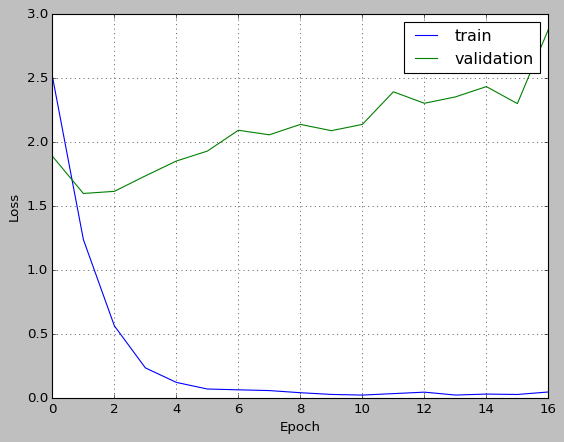

In [20]:
# plot the training curves
import matplotlib.pyplot as plt
plt.style.use("classic")
def plot_loss(history):
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='validation')
  #plt.ylim([0, 50])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
# after history = model.fit(...)
plot_loss(history)

#### Biggest challenge: getting validation loss down

In [ ]:
model.save('/content/drive/My Drive/plant_inceptionresnet_model')
#model.save('/content/drive/My Drive/plant_inceptionresnet_model_h5.h5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/plant_inceptionresnet_model/assets


## Try Image Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
def preprocess_gen(image):
    #resized_image = tf.image.resize(image, [224, 224])
    final_image = inception_resnet_v2.preprocess_input(image)
    return final_image

In [ ]:
#experimented with different parameters 
train_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2,
        preprocessing_function=preprocess_gen,
        validation_split=0.1)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_gen)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        subset='training')

val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        subset='validation')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32)

Found 2118 images belonging to 27 classes.
Found 222 images belonging to 27 classes.
Found 236 images belonging to 27 classes.


In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=nadam, metrics=["accuracy"])

In [ ]:
history = model.fit(train_generator, epochs=25, validation_data=val_generator, callbacks=monitor_val_acc)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/25
67/67 [==============================] - 92s 1s/step - loss: 1.0186 - accuracy: 0.7025 - val_loss: 1.3650 - val_accuracy: 0.6351
Epoch 2/25
67/67 [==============================] - 88s 1s/step - loss: 0.7364 - accuracy: 0.7748 - val_loss: 1.0559 - val_accuracy: 0.6892
Epoch 3/25
67/67 [==============================] - 87s 1s/step - loss: 0.5528 - accuracy: 0.8239 - val_loss: 1.0942 - val_accuracy: 0.6892
Epoch 4/25
67/67 [==============================] - 88s 1s/step - loss: 0.5019 - accuracy: 0.8390 - val_loss: 1.0908 - val_accuracy: 0.6667
Epoch 5/25
67/67 [==============================] - 87s 1s/step - loss: 0.4269 - accuracy: 0.8598 - val_loss: 1.1198 - val_accuracy: 0.6847
Epoch 6/25
67/67 [==============================] - 86s 1s/step - loss: 0.3909 - accuracy: 0.8749 - val_loss: 1.0275 - val_accuracy: 0.7297
Epoch 7/25
67/67 [==============================] - 86s 1s/step - loss: 0.3208 - accuracy: 0.8876 - val_loss: 1.1485 - val_accuracy: 0.7072
Epoch 8/25
67/67 [==

In [ ]:
model.evaluate(test_generator)

8/8 [==============================] - 6s 704ms/step - loss: 2.3289 - accuracy: 0.5720


[2.328927755355835, 0.5720338821411133]

### Xception Model

In [ ]:
from keras.applications import Xception
from keras.applications import xception

In [ ]:
def preprocess_xception(image, label):
    #resized_image = tf.image.resize(image, [224, 224])
    final_image = xception.preprocess_input(image)
    return final_image, label

In [ ]:
train_set = train_ds.map(preprocess_xception).prefetch(1)
valid_set = val_ds.map(preprocess_xception).prefetch(1)
test_set = test_ds.map(preprocess_xception).prefetch(1)

In [ ]:
tf.random.set_seed(123)
np.random.seed(123)
base_model = Xception(include_top=False, 
                               weights='imagenet', 
                               pooling='avg')

output = keras.layers.Dense(len(class_names), activation='softmax')(base_model.output)
model = keras.models.Model(inputs=base_model.inputs, outputs=output)
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer="nadam", 
    metrics=["accuracy"])
history = model.fit(train_set, epochs=25, validation_data=valid_set, callbacks=monitor_val_acc)
score = model.evaluate(test_set)

Epoch 1/25
66/66 [==============================] - 48s 727ms/step - loss: 2.0203 - accuracy: 0.3989 - val_loss: 3.2045 - val_accuracy: 0.2863
Epoch 2/25
66/66 [==============================] - 47s 709ms/step - loss: 1.0225 - accuracy: 0.6652 - val_loss: 2.4207 - val_accuracy: 0.4017
Epoch 3/25
66/66 [==============================] - 47s 714ms/step - loss: 0.6364 - accuracy: 0.8010 - val_loss: 3.1575 - val_accuracy: 0.3120
Epoch 4/25
66/66 [==============================] - 47s 712ms/step - loss: 0.4170 - accuracy: 0.8751 - val_loss: 1.9267 - val_accuracy: 0.4786
Epoch 5/25
66/66 [==============================] - 47s 712ms/step - loss: 0.2720 - accuracy: 0.9155 - val_loss: 2.0267 - val_accuracy: 0.5726
Epoch 6/25
66/66 [==============================] - 47s 707ms/step - loss: 0.1763 - accuracy: 0.9487 - val_loss: 2.7033 - val_accuracy: 0.4274
Epoch 7/25
66/66 [==============================] - 47s 706ms/step - loss: 0.2268 - accuracy: 0.9245 - val_loss: 1.9234 - val_accuracy: 0.5342

With data augmentation

In [ ]:
def preprocess_gen_x(image):
    #resized_image = tf.image.resize(image, [224, 224])
    final_image = xception.preprocess_input(image)
    return final_image

In [ ]:
train_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2,
        preprocessing_function=preprocess_gen_x,
        validation_split=0.1)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_gen_x)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        subset='training')

val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        subset='validation')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32)

Found 2118 images belonging to 27 classes.
Found 222 images belonging to 27 classes.
Found 236 images belonging to 27 classes.


In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=nadam, metrics=["accuracy"])

history = model.fit(train_generator, epochs=25, validation_data=val_generator, callbacks=monitor_val_acc)

model.evaluate(test_generator)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/25
67/67 [==============================] - 100s 1s/step - loss: 1.0998 - accuracy: 0.6808 - val_loss: 1.6066 - val_accuracy: 0.6126
Epoch 2/25
67/67 [==============================] - 96s 1s/step - loss: 0.7439 - accuracy: 0.7672 - val_loss: 0.9146 - val_accuracy: 0.7207
Epoch 3/25
67/67 [==============================] - 97s 1s/step - loss: 0.5748 - accuracy: 0.8069 - val_loss: 1.0278 - val_accuracy: 0.6847
Epoch 4/25
67/67 [==============================] - 101s 2s/step - loss: 0.4805 - accuracy: 0.8437 - val_loss: 0.8583 - val_accuracy: 0.7207
Epoch 5/25
67/67 [==============================] - 102s 2s/step - loss: 0.4244 - accuracy: 0.8617 - val_loss: 0.8976 - val_accuracy: 0.7568
Epoch 6/25
67/67 [==============================] - 99s 1s/step - loss: 0.3640 - accuracy: 0.8824 - val_loss: 0.8498 - val_accuracy: 0.7387
Epoch 7/25
67/67 [==============================] - 99s 1s/step - loss: 0.3464 - accuracy: 0.8782 - val_loss: 0.9005 - val_accuracy: 0.7252
Epoch 8/25
67/67 

[2.3551173210144043, 0.5932203531265259]

In [ ]:
model.save('/content/drive/My Drive/plant_xception_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/plant_xception_model/assets


### Transfer Model to GCS Bucket

In [ ]:
from google.colab import auth
auth.authenticate_user()

project_id = 'velvety-transit-295121'
!gcloud config set project {project_id}
!gsutil ls


Updated property [core/project].
gs://staging.velvety-transit-295121.appspot.com/
gs://sys6016_plant_image/
gs://us.artifacts.velvety-transit-295121.appspot.com/
gs://velvety-transit-295121.appspot.com/


In [ ]:
bucket_name = 'sys6016_plant_image/plant_xception_model'

!gsutil -m cp -r /content/drive/My\ Drive/plant_xception_model/* gs://{bucket_name}/

Copying file:///content/drive/My Drive/plant_xception_model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file:///content/drive/My Drive/plant_xception_model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file:///content/drive/My Drive/plant_xception_model/variables/variables.index [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects

In [ ]:
bucket_name = 'sys6016_plant_image/plant_inceptionresnet_model'

!gsutil -m cp -r /content/drive/My\ Drive/plant_inceptionresnet_model/* gs://{bucket_name}/

Copying file:///content/drive/My Drive/plant_inceptionresnet_model/variables/variables.index [Content-Type=application/octet-stream]...
Copying file:///content/drive/My Drive/plant_inceptionresnet_model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file:///content/drive/My Drive/plant_inceptionresnet_model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums